In [32]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from utils.preprocessing import clean_tweet_for_vader
import shap

# BERT data SHAP

In [33]:
# ========================================
# 1) Wczytanie danych
# ========================================

df = pd.read_csv("../data/bert_sentiment.csv") 
df["bert_clean2"] = df["bert_clean"].apply(clean_tweet_for_vader)
# Podział na trening i test
X_train, X_test, y_train, y_test = train_test_split(
    df["bert_clean2"],
    df["bert_sentiment_label"],
    test_size=0.2,
    random_state=42
)

In [34]:
# ========================================
# 2) Pipeline: TF-IDF + LogisticRegression 
# ========================================

pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=5000)),
    ('clf', LogisticRegression(max_iter=200, multi_class='multinomial', solver='lbfgs'))
])

pipeline.fit(X_train, y_train)


print("Accuracy:", pipeline.score(X_train, y_train))
print("Accuracy:", pipeline.score(X_test, y_test))

/Users/maciek_gangus/PycharmProjects/sentiment-analysis-shap/.venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Accuracy: 0.8511576944148093
Accuracy: 0.7909122361895975


In [35]:
# ========================================
# 3) SHAP - LinearExplainer
# ========================================

X_train_tfidf = pipeline.named_steps['tfidf'].transform(X_train).toarray()
X_test_tfidf = pipeline.named_steps['tfidf'].transform(X_test).toarray()

explainer = shap.LinearExplainer(
    pipeline.named_steps['clf'],
    X_train_tfidf
)

shap_values = explainer(X_test_tfidf)

print("SHAP shape:", shap_values.values.shape)

SHAP shape: (8671, 5000, 3)


===== Klasa: negative =====


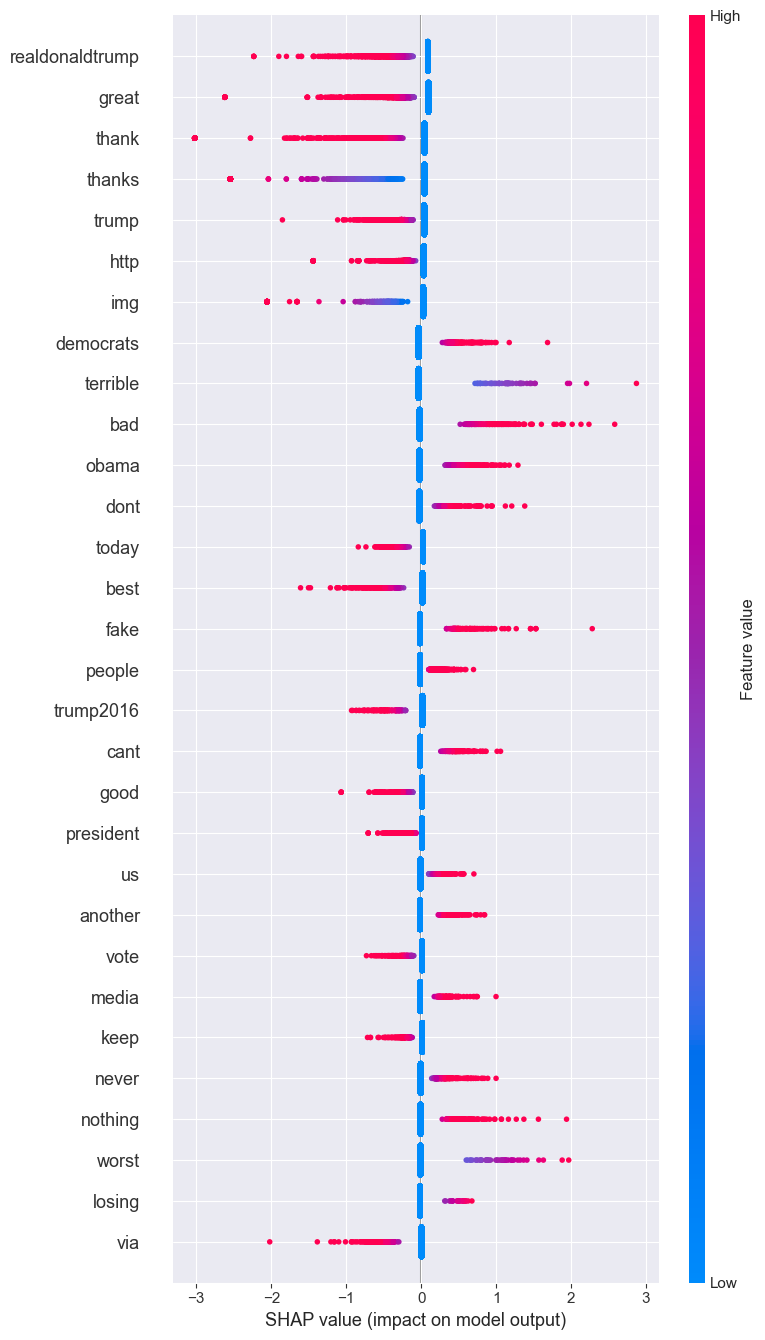

===== Klasa: neutral =====


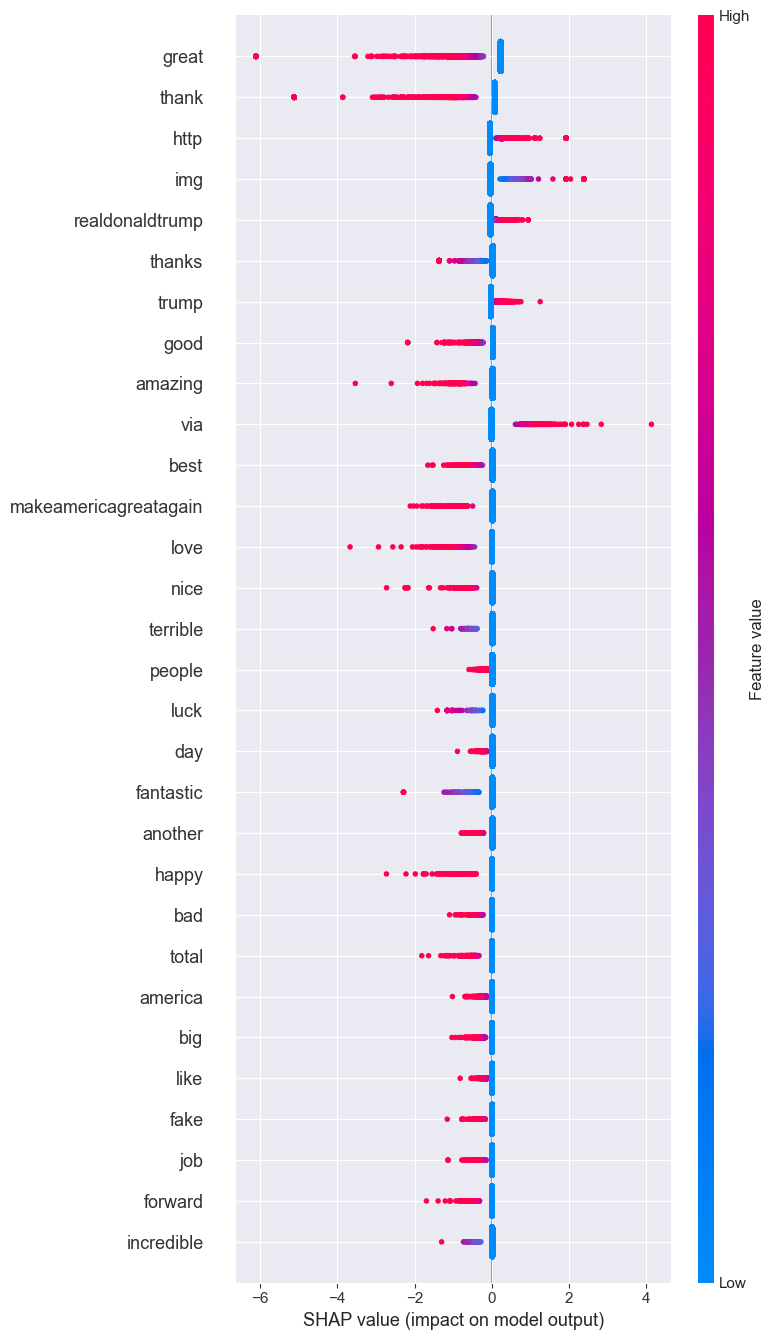

===== Klasa: positive =====


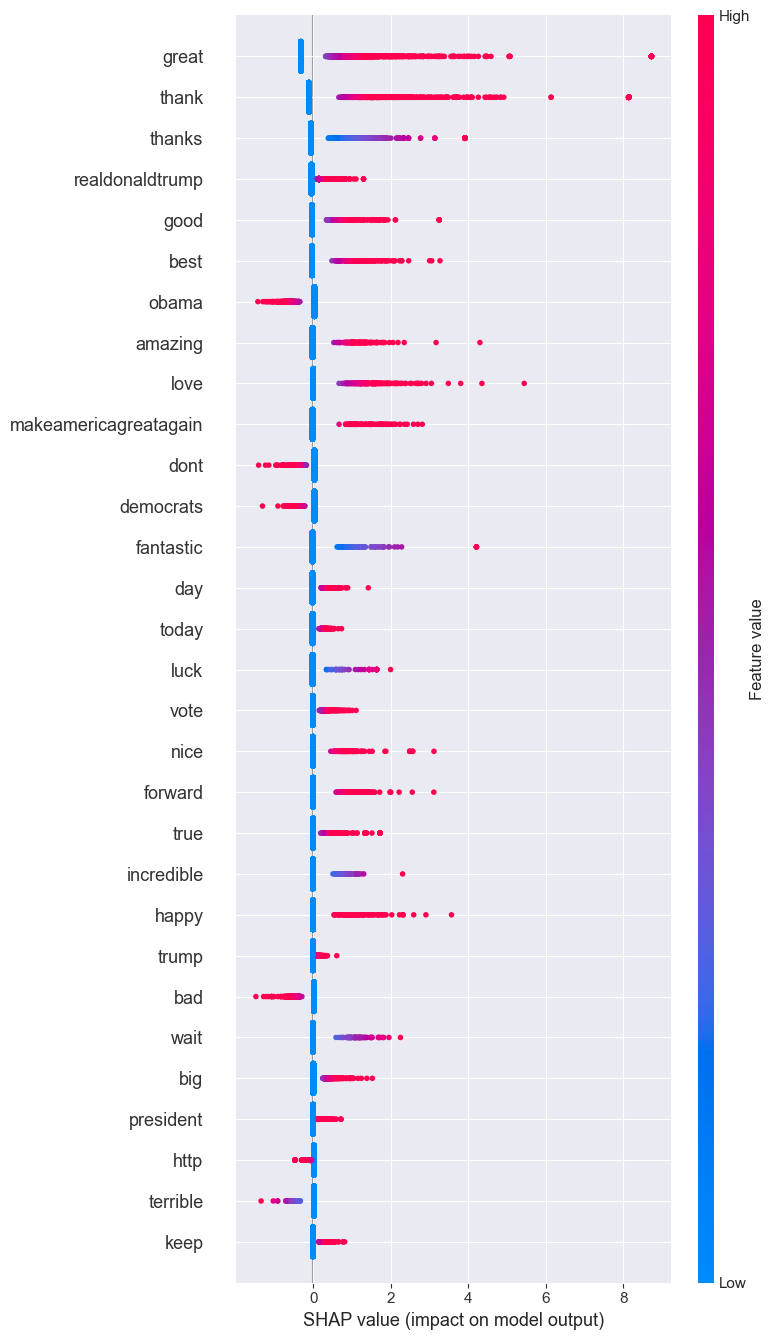

In [36]:
# ========================================
# 4) Beeswarm plot (summary_plot) - Z KOLORAMI
# ========================================

feature_names = pipeline.named_steps['tfidf'].get_feature_names_out()
class_names = pipeline.named_steps['clf'].classes_

X_test_df = pd.DataFrame(X_test_tfidf, columns=feature_names)

for i, class_name in enumerate(class_names):
    print(f"===== Klasa: {class_name} =====")
    shap.summary_plot(
        shap_values.values[:, :, i],
        X_test_df,
        feature_names=feature_names,
        plot_type='dot',
        show=True,
        max_display=30
    )
    

# VADER data SHAP

In [37]:
df = pd.read_csv("../data/vader_sentiment.csv") 

df = df.dropna(subset=["vader_clean", "vader_sentiment_label"])

X_train, X_test, y_train, y_test = train_test_split(
    df["vader_clean"],
    df["vader_sentiment_label"],
    test_size=0.2,
    random_state=42
)

In [38]:
# ========================================
# 2) Pipeline: TF-IDF + LogisticRegression (multi-class)
# ========================================

pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=5000)),
    ('clf', LogisticRegression(max_iter=200, multi_class='multinomial', solver='lbfgs'))
])

pipeline.fit(X_train, y_train)


print("Accuracy:", pipeline.score(X_train, y_train))
print("Accuracy:", pipeline.score(X_test, y_test))

/Users/maciek_gangus/PycharmProjects/sentiment-analysis-shap/.venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Accuracy: 0.9142782849878655
Accuracy: 0.8592395700912978


In [39]:
# ========================================
# 3) SHAP - LinearExplainer
# ========================================

X_train_tfidf = pipeline.named_steps['tfidf'].transform(X_train).toarray()
X_test_tfidf = pipeline.named_steps['tfidf'].transform(X_test).toarray()

explainer = shap.LinearExplainer(
    pipeline.named_steps['clf'],
    X_train_tfidf
)

shap_values = explainer(X_test_tfidf)

print("SHAP shape:", shap_values.values.shape)

SHAP shape: (8653, 5000, 3)


===== Klasa: negative =====


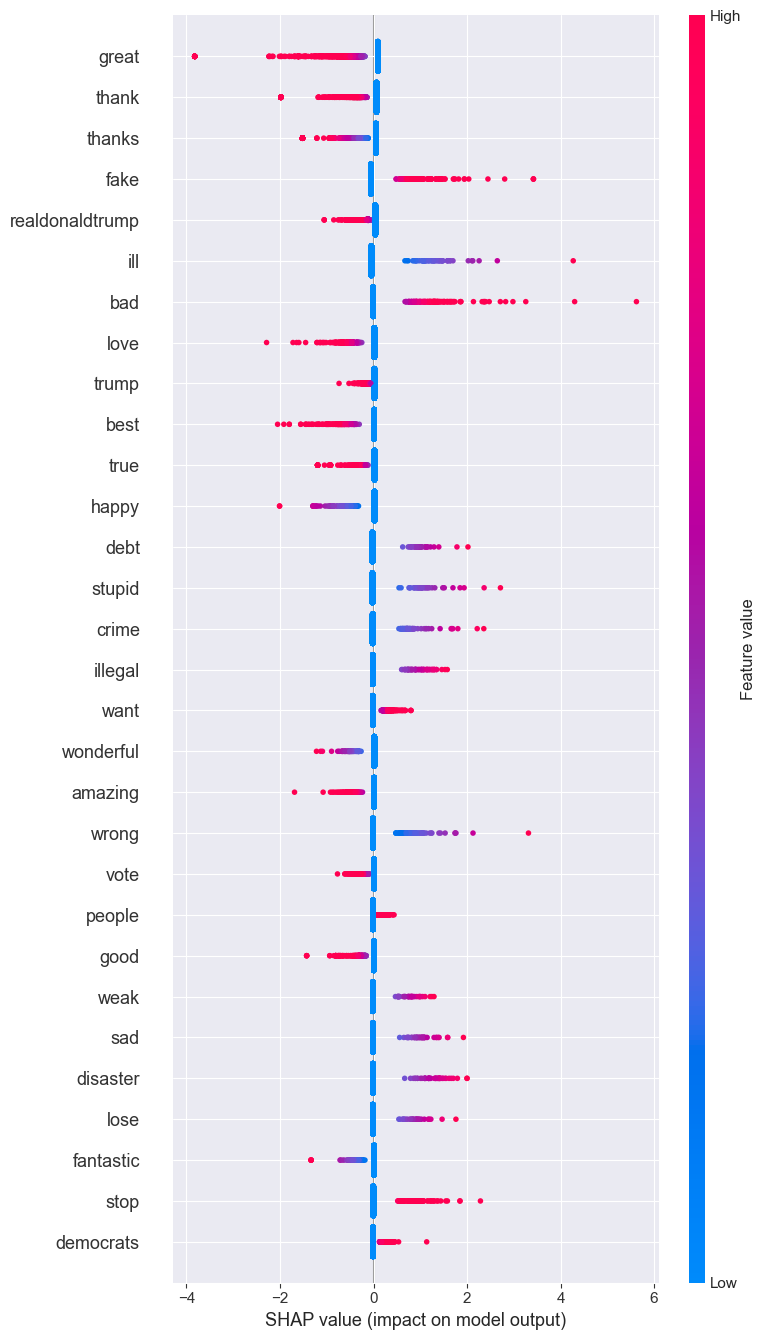

===== Klasa: neutral =====


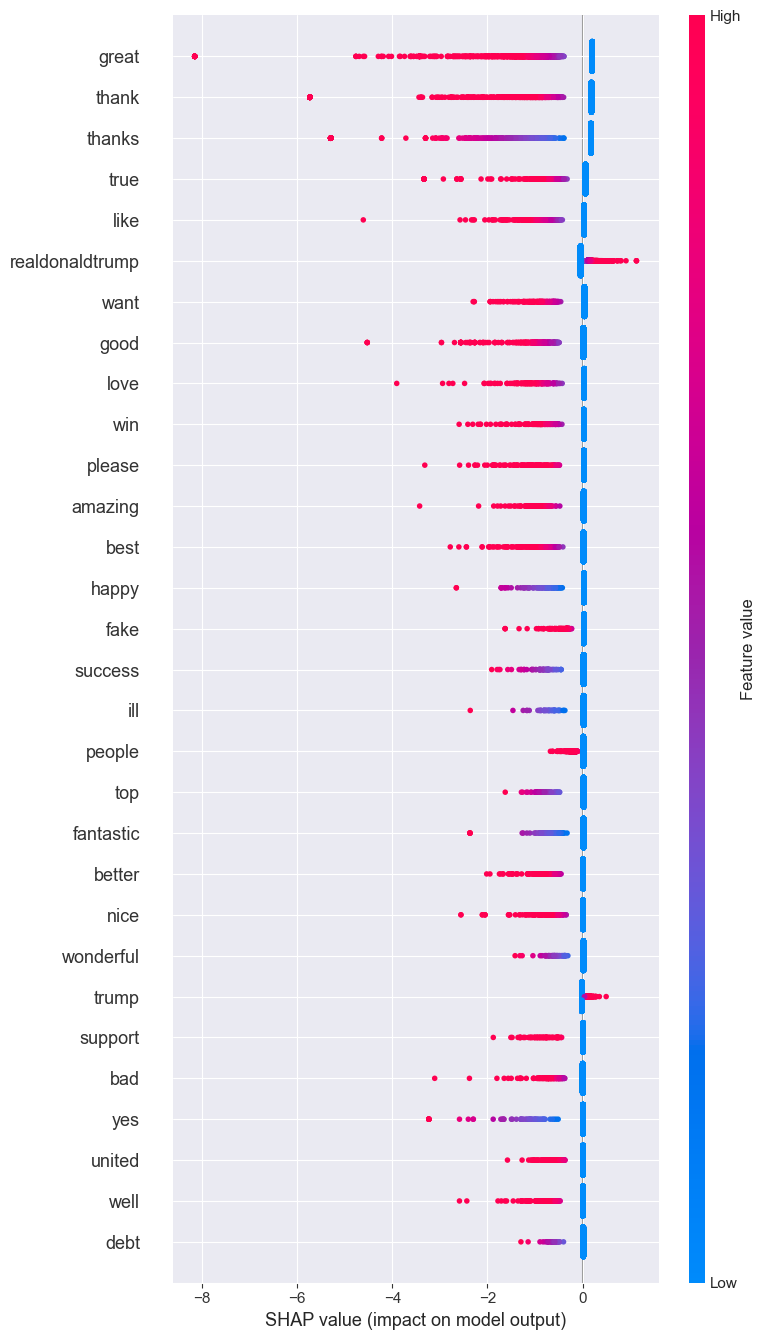

===== Klasa: positive =====


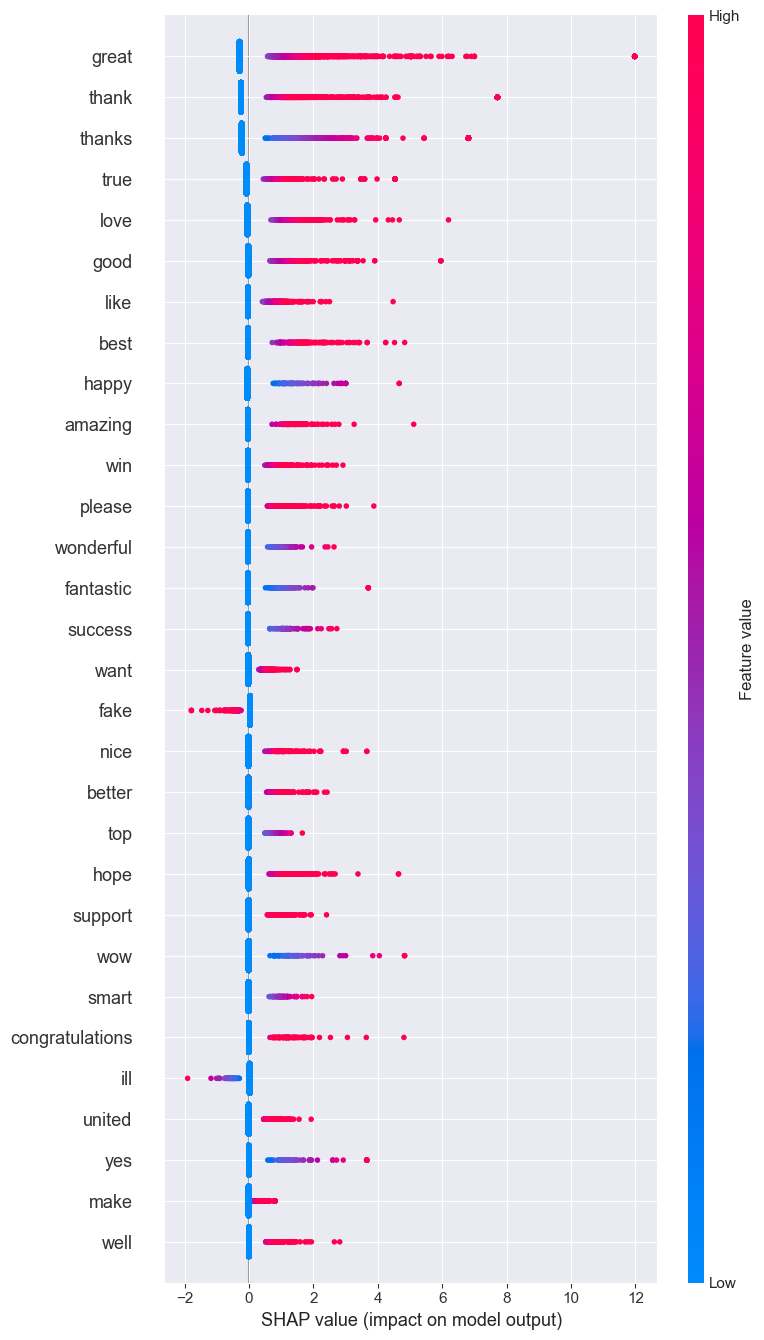

In [40]:
# ========================================
# 4) Beeswarm plot (summary_plot) - Z KOLORAMI
# ========================================

feature_names = pipeline.named_steps['tfidf'].get_feature_names_out()
class_names = pipeline.named_steps['clf'].classes_

X_test_df = pd.DataFrame(X_test_tfidf, columns=feature_names)

for i, class_name in enumerate(class_names):
    print(f"===== Klasa: {class_name} =====")
    shap.summary_plot(
        shap_values.values[:, :, i],
        X_test_df,
        feature_names=feature_names,
        plot_type='dot',
        show=True,
        max_display=30
    )